### Reproducing Trinity Study Results

The [Trinity Study](https://en.wikipedia.org/wiki/Trinity_study) is a famous stock market simulation. It is (maybe?) the source of the "4% Rule" for retirement planning, which advocates that your retirement fund in the first year of retirement be large enough that a 4% withdrawl covers the first year of expenses. 

One of the results from that paper is summaried by this graph

<img src="https://thepoorswiss.com/wp-content/uploads/2019/07/100-Stocks-1926-to-1995-Trinity-Study.png"/>

The `ConstantSpendStrategy` in `reire` implements a constant (inflation-adjusted) withdrawl, as well as simulated market performance based on historical data. We can use simulations to roughly reproduce the above results.

In [1]:
import pandas as pd
from plotnine import *

from retire import State
from retire.strategies import ConstantSpendStrategy

In [4]:
sims = pd.concat([
    ConstantSpendStrategy(standard_of_living=50_000, stock_fraction=1.0, verbose=False)
    # Simulate forward from a state with sufficient funds to satisfy the safe-withdrawal criterion.
    # Note that these simulations are truncated when the simulated retiree dies, which was not included in the
    # trinity study. We start the simulation at an early age, to minimize the effect of mortality.
    .simulate(State(age=30, retired=True, alive=True, assets=50_000 / wr * 100), time_horizon, 100)
    # Add columns for the parameters of each simulation batch
    .assign(wr=wr, time_horizon=time_horizon)
    for wr in range(3, 13) 
    for time_horizon in [15, 20, 25, 30]
], ignore_index=True)

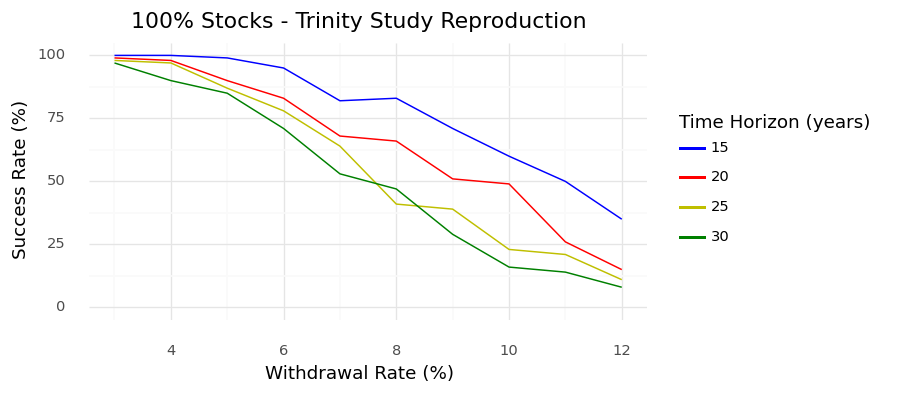

<ggplot: (162704518141)>

In [6]:
from plotnine import *
(
    sims
    # Compute whether the fund was depleted in each simulation
    .groupby(['wr', 'time_horizon', 'simulation']).spend.agg(lambda s: s.min() == 0)
    # Average over the simulations to get the failure rate for each withdrawal rate and time horizon 
    .groupby(level=[0, 1]).mean()
    .reset_index()
    .rename(columns={'spend': 'fail_rate'})
    # Plot
    .pipe(ggplot)
    + aes(x='wr', y='100 * (1-fail_rate)', color='factor(time_horizon)')
    + geom_line()
    + scale_color_manual(values=['b', 'r', 'y', 'g'], breaks=[15, 20, 25, 30])
    + labs(
        x='Withdrawal Rate (%)',
        y='Success Rate (%)',
        color='Time Horizon (years)',
        title='100% Stocks - Trinity Study Reproduction'
    )
    + scale_x_continuous(limits=[3, 12], breaks=[4, 6, 8, 10, 12])
    + scale_y_continuous(limits=[0, 100], breaks=[0, 25, 50, 75, 100])   
    + theme_minimal()
    + theme(
        figure_size=(6, 3),
        dpi=120
    )
)